In [ ]:
import os
import gzip
import missingno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import statsmodels.api as sm
from xgboost import XGBRegressor
from scipy.stats import randint as sp_randint

sns.set(style="whitegrid")

In [ ]:
df_patients = pd.read_csv(r'/kaggle/input/project-data/PATIENTS.csv/PATIENTS.csv',usecols=[0,1,2,3])
df_patients.head(5)

In [ ]:
np.unique(df_patients['SUBJECT_ID'].unique)

In [ ]:
print('Total Number of patients:' , df_patients['SUBJECT_ID'].nunique())

In [ ]:
df_patients['GENDER'].value_counts()

In [ ]:
#Convert DOB to Datetime
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'])

In [ ]:
df_patients = df_patients[['SUBJECT_ID', 'GENDER','DOB',]]
df_patients.head()

In [ ]:
df_admissions = pd.read_csv(r"/kaggle/input/project-data/ADMISSIONS.csv/ADMISSIONS.csv")
df_admissions.head(5)  

In [ ]:
missingno.heatmap(df_admissions)

In [ ]:
# missingno.bar(df_admissions)

In [ ]:
df_admissions.isnull().sum()

In [ ]:
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'])
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'])
df_admissions['LOS'] = (df_admissions['DISCHTIME'] - df_admissions['ADMITTIME']).dt.total_seconds()/86400

In [ ]:
df_admissions['HADM_ID'].nunique()

In [ ]:
df_admissions.describe().round(0)

In [ ]:
df_admissions = df_admissions[df_admissions['LOS']>0]

In [ ]:
df_admissions.describe().round(0)

In [ ]:
print(f"{df_admissions['HOSPITAL_EXPIRE_FLAG'].sum()} of {df_admissions['SUBJECT_ID'].nunique()} patients died in the hospital.")

In [ ]:
df_admissions['ETHNICITY'].value_counts(dropna=False)

In [ ]:
# Define the replacement mapping
ethnicity_mapping = {
    r'^ASIAN\D*': 'ASIAN',
    r'^WHITE\D*': 'WHITE',
    r'^HISPANIC\D*': 'HISPANIC/LATINO',
    r'^BLACK\D*': 'BLACK/AFRICAN AMERICAN',
    'UNABLE TO OBTAIN': 'OTHER/UNKNOWN',
    'OTHER': 'OTHER/UNKNOWN',
    'PATIENT DECLINED TO ANSWER': 'OTHER/UNKNOWN',
    'UNKNOWN/NOT SPECIFIED': 'OTHER/UNKNOWN'
}

# Apply the replacements using regex
df_admissions['ETHNICITY'] = df_admissions['ETHNICITY'].replace(ethnicity_mapping, regex=True)

# Identify the top 5 most frequent ethnicities
top_ethnicities = df_admissions['ETHNICITY'].value_counts().nlargest(5).index.tolist()

# Replace less frequent ethnicities with 'OTHER/UNKNOWN'
df_admissions.loc[~df_admissions['ETHNICITY'].isin(top_ethnicities), 'ETHNICITY'] = 'OTHER/UNKNOWN'
df_admissions['ETHNICITY'].value_counts()

In [ ]:
df_admissions['INSURANCE'].value_counts(dropna=False)

In [ ]:
df_admissions['RELIGION'] = df_admissions['RELIGION'].fillna('NOT SPECIFIED')
df_admissions['RELIGION'].value_counts(dropna=False)

In [ ]:
df_admissions['MARITAL_STATUS'].value_counts(dropna=False)
df_admissions['MARITAL_STATUS'] = df_admissions['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df_admissions['MARITAL_STATUS'].value_counts(dropna=False)

### ICU Stays Processing

In [ ]:
df_icuStays = pd.read_csv(r"/kaggle/input/project-data/ICUSTAYS.csv/ICUSTAYS.csv")
df_icuStays.head(5)    

In [ ]:
df_icuStays.shape

In [ ]:
#Unique Admission ID
print('Unique Admission ID in ICU',df_icuStays['HADM_ID'].nunique())
print('Unique Stays ID in ICU',df_icuStays['ICUSTAY_ID'].nunique())
print('Unique Patients in ICU',df_icuStays['SUBJECT_ID'].nunique())

In [ ]:
print('Repeated ICU patients',df_icuStays['SUBJECT_ID'].duplicated().sum())
print('Repeated ICU patients for same Admission ID',df_icuStays['HADM_ID'].duplicated().sum())

In [ ]:
df_icuStays_sum = df_icuStays.groupby(['HADM_ID'])['LOS'].sum().reset_index()

In [ ]:
df_icuStays_sum.describe().round(0)

#### Plotting the LOS Histogram

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df_icuStays_sum['LOS'], bins=200, color='#55a868', kde=True)

plt.xlim(0, 50)

mean_los = df_icuStays_sum['LOS'].mean()
median_los = df_icuStays_sum['LOS'].median()
plt.axvline(mean_los, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_los:.2f}')
plt.axvline(median_los, color='b', linestyle='-', linewidth=2, label=f'Median: {median_los:.2f}')

plt.title('Distribution of Length of Stay (LOS)', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('LOS (days)', fontsize=14)

plt.tick_params(top=False, right=False)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.legend()

plt.show()

In [ ]:
df_icuStays_sum.shape, df_admissions.shape

In [ ]:
df_diagnoses = pd.read_csv(r"/kaggle/input/project-data/DIAGNOSES_ICD.csv/DIAGNOSES_ICD.csv")
df_diagnoses = df_diagnoses[['HADM_ID','ICD9_CODE']]
df_diagnoses.head(5)

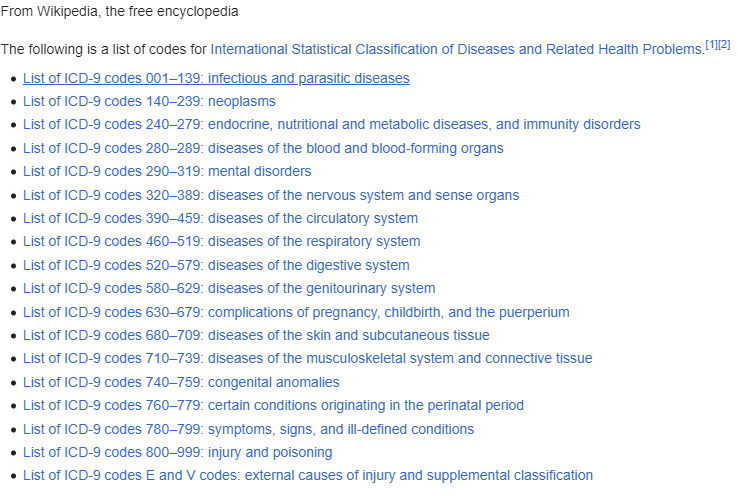

In [ ]:
df_diagnoses['code'] = df_diagnoses['ICD9_CODE']
df_diagnoses['code'] = df_diagnoses['code'][~df_diagnoses['code'].str.contains("[a-zA-Z]", na=False)]
df_diagnoses['code'] = df_diagnoses['code'].fillna('999')
df_diagnoses['code'] = df_diagnoses['code'].str.slice(start=0, stop=3, step=1)
df_diagnoses['code'] = df_diagnoses['code'].astype(int)

In [ ]:
df_diagnoses['code'].describe()

In [ ]:
df_diagnoses[df_diagnoses['code'] > 700]

In [ ]:
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000)]

mapping_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury'}

In [ ]:
for i, (lower, upper) in enumerate(icd9_ranges):
    df_diagnoses['code'] = np.where(df_diagnoses['code'].between(lower, upper), i, df_diagnoses['code'])   

df_diagnoses['category'] = df_diagnoses['code'].map(mapping_dict)    
df_diagnoses.head(5)

In [ ]:
df_diagnoses_pivot = df_diagnoses.groupby('HADM_ID')['category'].apply(list).reset_index()
df_diagnoses_pivot.head(5)

In [ ]:
df_diagnoses_pivot['count_diagnoses'] = df_diagnoses_pivot['category'].apply(len)
df_diagnoses_pivot.head(5)

In [ ]:
exploded = df_diagnoses_pivot['category'].explode()
dummies = pd.get_dummies(exploded)
hadm_item = dummies.groupby(level=0).sum()
hadm_item.head()

In [ ]:
hadm_item = hadm_item.join(df_diagnoses_pivot[['HADM_ID','count_diagnoses']], how="outer")
hadm_item.head()

In [ ]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the integer column
hadm_item['count_diagnoses'] = scaler.fit_transform(hadm_item[['count_diagnoses']])

### Merge Diagnosis with Admission

In [ ]:
df = df_admissions.merge(hadm_item, how='inner', on='HADM_ID')
df.head()

### Merging patients with the above dataframe

In [ ]:
df = df.merge(df_patients, how='inner', on='SUBJECT_ID')
df.head(6)

In [ ]:
df[df['SUBJECT_ID'] == 23]

In [ ]:
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMITTIME_MIN']
df_age_min.head()

In [ ]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df['DOB_YEAR'] = df['DOB'].dt.year
df['ADMITTIME_MIN_YEAR'] = df['ADMITTIME_MIN'].dt.year

In [ ]:
df['age'] = (df['ADMITTIME_MIN_YEAR'] - df['DOB_YEAR'])
df['age'] = np.where(df['age'] > 90, 90, df['age'])

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, color='#4e79a7', kde=True)

# Add mean line
mean_age = df['age'].mean()
plt.axvline(mean_age, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_age:.2f}')

# Labels and title
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')

# Customize ticks and grid
plt.tick_params(left=False, bottom=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
age_buckets = [(0, 1), (1, 10), (10,20),(20, 36), (36, 55), (55, 100)]
for n, r in enumerate(age_buckets):
    df['age'] = np.where(df['age'].between(r[0],r[1]), 
            n, df['age'])
    
age_dict = {0: 'newborn', 1: 'young', 2: 'teenage', 3: 'middle_age', 4: 'senior', 5: 'old'}
df['age'] = df['age'].replace(age_dict)
df.age.value_counts()

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='age', y='LOS', data=df, palette='viridis')

plt.ylabel('Length of Stay (days)', fontsize=14)
plt.xlabel('Age Group (years)', fontsize=14)
plt.title('Age Group versus Length-of-Stay', fontsize=16)

plt.ylim(1, 50)

plt.tick_params(top=False, right=False)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.show()

In [ ]:
df['GENDER'] = df['GENDER'].map({'M': 0, 'F': 1})

In [ ]:
df.loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE', 'OTHER']), 'RELIGION'] = 'RELIGIOUS'

In [ ]:
df.info()

In [ ]:
df.drop(columns=['ROW_ID','SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMITTIME_MIN', 'DOB',
                'DIAGNOSIS', 'DEATHTIME','ADMITTIME_MIN_YEAR','DOB_YEAR','EDREGTIME','DISCHTIME','EDOUTTIME','HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA'], inplace=True)

In [ ]:
prefix_cols = ['ADMISSION', 'INSURANCE', 'RELIGION', 'ETHNICITY', 'AGE', 'MARRIED',]
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
df.info()

In [ ]:
df.shape

In [ ]:
label = df['LOS'].values
features = df.drop(columns=['LOS'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features,label,test_size = .20,random_state = 42)

print(f"Training: {X_train.shape[0]} samples.")
print(f"Test: {X_test.shape[0]} samples.")

In [ ]:
models = [
    SGDRegressor(random_state=42), 
    GradientBoostingRegressor(random_state=42), 
    LinearRegression(),
    KNeighborsRegressor(),
    RandomForestRegressor(random_state=42),
    Ridge(),
    XGBRegressor(random_state=42),
    SVR()
]

results = {}

for model in models:

    model.fit(X_train, y_train)

    y_test_preds = model.predict(X_test)
    
    name = model.__class__.__name__

    r2 = r2_score(y_test, y_test_preds)

    rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

    results[name] = {'R-squared': r2, 'RMSE': rmse}
    
    print(f'{name} ---> R-squared: {r2:.4f}, RMSE: {rmse:.4f}')

results_df = pd.DataFrame(results).T
print(results_df)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                   n_iter=100, cv=kf, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_

print(f"Best Score: {random_search.best_score_}")
print(f"Best Estimator: {random_search.best_estimator_}")

y_test_preds = best_xgb_model.predict(X_test)

r2 = r2_score(y_test, y_test_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

print(f'R-squared: {r2:.4f}, RMSE: {rmse:.4f}')

In [ ]:
feature_imp = pd.DataFrame(best_xgb_model.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

In [ ]:
np.random.seed(42)

In [ ]:
random_indices = np.random.choice(len(y_test), 30, replace=False)

y_test_30 = y_test[random_indices]
y_test_preds_30 = y_test_preds[random_indices]

# Generate indices for the bars
indices = np.arange(len(y_test_30))

# Set the width of the bars
bar_width = 0.35

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the actual LOS
ax.bar(indices, y_test_30, bar_width, color='blue', label='Actual LOS')

# Plot the predicted LOS
ax.bar(indices + bar_width, y_test_preds_30, bar_width, color='red', label='Predicted LOS')

# Add labels, title, and legend
ax.set_xlabel('Sample Index')
ax.set_ylabel('LOS (days)')
ax.set_title('Actual vs Predicted LOS for 30 Samples')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(indices)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 10),
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_features': ['sqrt', 'log2']
}

# Create the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Create the RandomizedSearchCV object
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, 
                                      n_iter=100, cv=kf, random_state=42, n_jobs=-1)

# Fit the model
random_search_gb.fit(X_train, y_train)

# Get the best model from the randomized search
best_gb_model = random_search_gb.best_estimator_

# Print the best score and best estimator
print(f"Best Score: {random_search_gb.best_score_}")
print(f"Best Estimator: {random_search_gb.best_estimator_}")

# Predict on the test set
y_test_preds_gb = best_gb_model.predict(X_test)

# Calculate R-squared and RMSE
r2_gb = r2_score(y_test, y_test_preds_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_preds_gb))

print(f'R-squared: {r2_gb:.4f}, RMSE: {rmse_gb:.4f}')

In [ ]:
random_indices = np.random.choice(len(y_test), 30, replace=False)

y_test_30 = y_test[random_indices]
y_test_preds_30 = y_test_preds_gb[random_indices]

indices = np.arange(len(y_test_30))

bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(indices, y_test_30, bar_width, color='blue', label='Actual LOS')

ax.bar(indices + bar_width, y_test_preds_30, bar_width, color='red', label='Predicted LOS')

ax.set_xlabel('Sample Index')
ax.set_ylabel('LOS (days)')
ax.set_title('Actual vs Predicted LOS for 30 Random Samples')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(indices)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Convert DataFrame and target array to NumPy arrays
X_numpy = features.to_numpy()
y_numpy = label

# Convert NumPy arrays to TensorFlow tensors
X = tf.convert_to_tensor(X_numpy, dtype=tf.float32)
y = tf.convert_to_tensor(y_numpy, dtype=tf.float32)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# Convert the split data back to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

input_shape = X_train.shape[1] 
# Build the model
model = Sequential([
    Input(shape=(input_shape,)),  # Input layer with specified shape
    Dense(64, activation='relu'),  # Hidden layer with 64 units
    Dense(32, activation='relu'),  # Hidden layer with 32 units
    Dense(1)  # Output layer with 1 unit
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict on the test set
y_test_preds = model.predict(X_test)

# Calculate R-squared and RMSE
r2 = r2_score(y_test, y_test_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

print(f'R-squared: {r2:.4f}, RMSE: {rmse:.4f}')